In [1]:
from typing import Tuple, List, Text, Dict, Any, Iterator, Union, Sized, Callable

import time
import sys

sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

import skimage.io as io
import numpy as np

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.backend import set_image_data_format
set_image_data_format("channels_last") # tensorflow

from chainer.iterators import MultiprocessIterator, SerialIterator
from chainer.dataset import dataset_mixin

from imgaug import augmenters as iaa

sys.path.append("./coco/PythonAPI/")
from pycocotools.coco import COCO
from pycocotools import mask
coco = COCO("./annotations/instances_train2014.json")

def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

Using TensorFlow backend.


loading annotations into memory...
Done (t=20.36s)
creating index...
index created!


In [24]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
    iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_px={"x": (-16, 16), "y": (-16, 16)}, # translate by -16 to +16 pixels (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            #order=iaa.ALL, # use any of scikit-image's interpolation methods
            #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode="wrap" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    ),
]).to_deterministic() # type: iaa.Sequential

In [29]:
cats_num = len([cat['name'] for cat in coco.loadCats(coco.getCatIds())]) # type: int

class CamVid(dataset_mixin.DatasetMixin):
    def __init__(self):
            self.infos = coco.loadImgs(coco.getImgIds(catIds=coco.getCatIds(catNms=['person']))) # type: List[dict]
    def __len__(self):
        return len(self.infos)
    def get_example(self, i):
        info = self.infos[i]
        img, mask = load_img(info)
        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        img = seq.augment_images(img)
        mask = seq.augment_images(mask)
        img = np.squeeze(img)
        mask = np.squeeze(mask)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        return (img, mask)

def load_img(imgInfo: dict) -> Tuple[np.ndarray, np.ndarray]:
    img = io.imread(imgInfo['coco_url'])
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[imgInfo['id']],iscrowd=False)) # type: List[dict]
    mask_all = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for ann in anns:
        cat = coco.loadCats([ann["category_id"]])[0]
        if cat["name" ] != "person": continue
        rles = mask.frPyObjects(ann["segmentation"], img.shape[0], img.shape[1]) # type: List[dict]
        for i, rle in enumerate(rles):
            mask_img = mask.decode(rle) # type: np.ndarray
            mask_img[mask_img > 0] = 255
            mask_all += mask_img
    return (img, mask_all)



In [30]:
def convert_to_keras_batch(iter: Iterator[List[Tuple[np.ndarray, np.ndarray]]]) -> Iterator[Tuple[np.ndarray, np.ndarray]] :
    while True:
        batch = iter.__next__() # type: List[Tuple[np.ndarray, np.ndarray]]
        xs = [x for (x, _) in batch] # type: List[np.ndarray]
        ys = [y for (_, y) in batch] # type: List[np.ndarray]
        _xs = np.array(xs) # (n, 480, 360, 3)
        _ys = np.array(ys) # (n, 480, 360, n_classes)
        yield (_xs, _ys)


In [31]:
train_iter = convert_to_keras_batch(
    SerialIterator(
    #MultiprocessIterator(
        CamVid(),
        batch_size=1,
        #n_processes=2,
        #n_prefetch=2,
        #shared_mem=1000*1000*5
    )
)


person
person
person
person
person
person
person
person
person
person
person
person
person
person
person
person


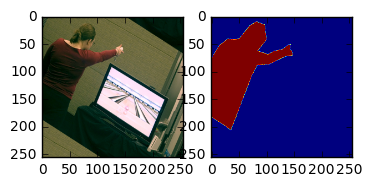

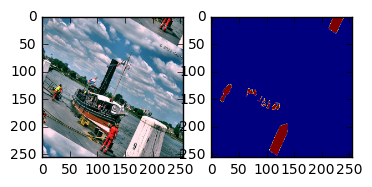

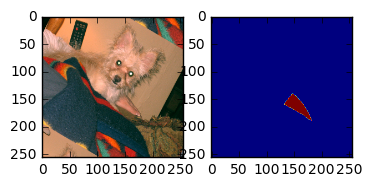

In [33]:
for (a,b), _ in zip(train_iter, range(3)):
    mtx_plot([[lambda x: plt.imshow(np.squeeze(a)), lambda x: plt.imshow(np.squeeze(b))]], (2, 2))